### Import Packages

In [1]:
import argparse
import os
import time
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorlayer as tl

### Basic Configuration

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#####################  hyper parameters  ####################

ENV_NAME = 'Pendulum-v0'    # environment name
RANDOMSEED = 1              # random seed
TRAIN = True

LR_A = 0.001                # learning rate for actor
LR_C = 0.002                # learning rate for critic
GAMMA = 0.9                 # reward discount
TAU = 0.01                  # soft replacement
MEMORY_CAPACITY = 10000     # size of replay buffer
BATCH_SIZE = 32             # update batchsize

MAX_EPISODES = 200          # total number of episodes for training
MAX_EP_STEPS = 200          # total number of steps for each episode
TEST_PER_EPISODES = 10      # test the model per episodes
VAR = 3                     # control exploration

### DDPG

In [3]:
class DDPG(object):
    """
    DDPG class
    """
    def __init__(self, a_dim, s_dim, a_bound):
        # replay buffer
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        # action dimension, state dimension, action value range
        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound
        # neural network parameters
        W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        b_init = tf.constant_initializer(0.1)

        def get_actor(input_state_shape):
            # Input layer
            inputs = tl.layers.Input(input_state_shape, name='A_input')
            # Dense Layer x 2
            x = tl.layers.Dense(n_units=30, act=tf.nn.relu, W_init=W_init, b_init=b_init, name='A_l1')(inputs)
            x = tl.layers.Dense(n_units=a_dim, act=tf.nn.tanh, W_init=W_init, b_init=b_init, name='A_a')(x)
            # The range of limit a is - 1 to 1
            x = tl.layers.Lambda(lambda x: np.array(a_bound) * x)(x)            
            return tl.models.Model(inputs=inputs, outputs=x)

        def get_critic(input_state_shape, input_action_shape):
            # Input layer for state and action
            s = tl.layers.Input(input_state_shape, name='C_s_input')
            a = tl.layers.Input(input_action_shape, name='C_a_input')
            # concatenate state and action as one input
            x = tl.layers.Concat(1)([s, a])
            # Dense Layer x 2
            x = tl.layers.Dense(n_units=60, act=tf.nn.relu, W_init=W_init, b_init=b_init, name='C_l1')(x)
            x = tl.layers.Dense(n_units=1, W_init=W_init, b_init=b_init, name='C_out')(x)
            return tl.models.Model(inputs=[s, a], outputs=x)
        
        # init actor and critic network
        self.actor = get_actor([None, s_dim])
        self.critic = get_critic([None, s_dim], [None, a_dim])
        # set mode to train: parameters will be optimized
        self.actor.train()
        self.critic.train()

        # update target network
        def copy_para(from_model, to_model):
            for i, j in zip(from_model.trainable_weights, to_model.trainable_weights):
                j.assign(i)

        # build target network for actor
        self.actor_target = get_actor([None, s_dim])
        copy_para(self.actor, self.actor_target)
        # set mode to eval: parameters wont be optimized
        # parameters of actor target network is copied from actor network every once in a while
        # so there is no need to train the target network
        self.actor_target.eval()

        # build target network for critic
        self.critic_target = get_critic([None, s_dim], [None, a_dim])
        copy_para(self.critic, self.critic_target)
        self.critic_target.eval()

        self.R = tl.layers.Input([None, 1], tf.float32, 'r')

        # calculate moving average
        self.ema = tf.train.ExponentialMovingAverage(decay=1 - TAU)  # soft replacement
        
        # set Optimizers as Adam
        self.actor_opt = tf.optimizers.Adam(LR_A)
        self.critic_opt = tf.optimizers.Adam(LR_C)


    def ema_update(self):
        # Moving average update
        paras = self.actor.trainable_weights + self.critic.trainable_weights   
        self.ema.apply(paras)                                                  
        for i, j in zip(self.actor_target.trainable_weights + self.critic_target.trainable_weights, paras):
            i.assign(self.ema.average(j))                                       

    def choose_action(self, s):
        # Input state and get the responding action
        return self.actor(np.array([s], dtype=np.float32))[0]

    def learn(self):
        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)    # choose BATCH_SIZE indexes of samples
        bt = self.memory[indices, :]                    # select samples
        bs = bt[:, :self.s_dim]                         # get data
        ba = bt[:, self.s_dim:self.s_dim + self.a_dim] 
        br = bt[:, -self.s_dim - 1:-self.s_dim]         
        bs_ = bt[:, -self.s_dim:]                       

        # Critic update
        with tf.GradientTape() as tape:
            a_ = self.actor_target(bs_)
            q_ = self.critic_target([bs_, a_])
            y = br + GAMMA * q_ # target value
            q = self.critic([bs, ba]) # network outputs
            td_error = tf.losses.mean_squared_error(y, q) # calculate loss
        c_grads = tape.gradient(td_error, self.critic.trainable_weights) # do gradient descent
        self.critic_opt.apply_gradients(zip(c_grads, self.critic.trainable_weights)) # use Adam to update parameters

        # Actor update
        with tf.GradientTape() as tape:
            a = self.actor(bs)
            q = self.critic([bs, a])
            a_loss = -tf.reduce_mean(q)  # Add a minus sign for gradient ascent
        a_grads = tape.gradient(a_loss, self.actor.trainable_weights)
        self.actor_opt.apply_gradients(zip(a_grads, self.actor.trainable_weights))

        self.ema_update()

    def store_transition(self, s, a, r, s_):
        s = s.astype(np.float32)
        s_ = s_.astype(np.float32)
        # stack s, a, [r], s_ horizontally
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def save_ckpt(self):
        if not os.path.exists('model'):
            os.makedirs('model')
        tl.files.save_weights_to_hdf5('model/ddpg_actor.hdf5', self.actor)
        tl.files.save_weights_to_hdf5('model/ddpg_actor_target.hdf5', self.actor_target)
        tl.files.save_weights_to_hdf5('model/ddpg_critic.hdf5', self.critic)
        tl.files.save_weights_to_hdf5('model/ddpg_critic_target.hdf5', self.critic_target)

    def load_ckpt(self):
        tl.files.load_hdf5_to_weights_in_order('model/ddpg_actor.hdf5', self.actor)
        tl.files.load_hdf5_to_weights_in_order('model/ddpg_actor_target.hdf5', self.actor_target)
        tl.files.load_hdf5_to_weights_in_order('model/ddpg_critic.hdf5', self.critic)
        tl.files.load_hdf5_to_weights_in_order('model/ddpg_critic_target.hdf5', self.critic_target)

### Main Function

In [4]:
# init environment
env = gym.make(ENV_NAME)
env = env.unwrapped

# seed for reproducibility
env.seed(RANDOMSEED)
np.random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

# s_dim: state dimension
# a_dim: action dimension
# a_bound: action range(bound)
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
a_bound = env.action_space.high
print('s_dim',s_dim)
print('a_dim',a_dim)

# init model
ddpg = DDPG(a_dim, s_dim, a_bound)

if TRAIN:  # train
    
    reward_buffer = []
    t0 = time.time()
    for i in range(MAX_EPISODES):
        t1 = time.time()
        s = env.reset()
        ep_reward = 0 
        for j in range(MAX_EP_STEPS):
            a = ddpg.choose_action(s)
            # Add exploration noise
            # take a as the mean and VAR as the standard deviation to establish a normal distribution
            # then sample a from the normal distribution
            a = np.clip(np.random.normal(a, VAR), -2, 2)  
            s_, r, done, info = env.step(a)
            ddpg.store_transition(s, a, r / 10, s_)
    
            # start training while has enough size of replay buffer
            if ddpg.pointer > MEMORY_CAPACITY:
                ddpg.learn()

            s = s_  
            ep_reward += r
            if j == MAX_EP_STEPS - 1:
                print(
                    '\rEpisode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                        i, MAX_EPISODES, ep_reward,
                        time.time() - t1
                    ), end=''
                )
            plt.show()
        
        # test
        if i and not i % TEST_PER_EPISODES:
            t1 = time.time()
            s = env.reset()
            ep_reward = 0
            for j in range(MAX_EP_STEPS):

                a = ddpg.choose_action(s)
                s_, r, done, info = env.step(a)

                s = s_
                ep_reward += r
                if j == MAX_EP_STEPS - 1:
                    print(
                        '\rEpisode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                            i, MAX_EPISODES, ep_reward,
                            time.time() - t1
                        )
                    )

                    reward_buffer.append(ep_reward)

s_dim 3
a_dim 1
[TL] Input  A_input: [None, 3]
[TL] Dense  A_l1: 30 relu
[TL] Dense  A_a: 1 tanh
[TL] Lambda  lambda_1: func: <function DDPG.__init__.<locals>.get_actor.<locals>.<lambda> at 0x7fd8f3734f80>, len_weights: 0
[TL] Input  C_s_input: [None, 3]
[TL] Input  C_a_input: [None, 1]
[TL] Concat concat_1: concat_dim: 1
[TL] Dense  C_l1: 60 relu
[TL] Dense  C_out: 1 No Activation
[TL] Input  A_input: [None, 3]
[TL] Dense  A_l1: 30 relu
[TL] Dense  A_a: 1 tanh
[TL] Lambda  lambda_2: func: <function DDPG.__init__.<locals>.get_actor.<locals>.<lambda> at 0x7fd8f37ef830>, len_weights: 0
[TL] Input  C_s_input: [None, 3]
[TL] Input  C_a_input: [None, 1]
[TL] Concat concat_2: concat_dim: 1
[TL] Dense  C_l1: 60 relu
[TL] Dense  C_out: 1 No Activation
[TL] Input  r: [None, 1]
Episode: 10/200  | Episode Reward: -1616.8851  | Running Time: 0.1234
Episode: 20/200  | Episode Reward: -1541.3810  | Running Time: 0.1231
Episode: 30/200  | Episode Reward: -1393.3112  | Running Time: 0.1283
Episode: 40

### Recording data

In [5]:
with open(f"./rewards/o_rewards_{ENV_NAME}.txt", "a") as fp:
    for i in range(10, 200, 10):
        fp.write(f"{i} {reward_buffer[i//10-1]:.5f}\n")

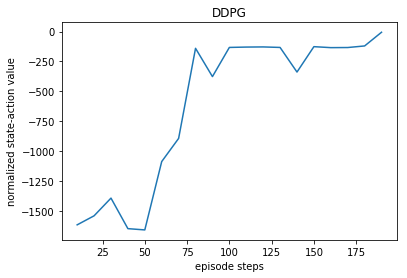


Running time:  384.79074692726135
[TL] [*] Saving TL weights into model/ddpg_actor.hdf5
[TL] [*] Saved
[TL] [*] Saving TL weights into model/ddpg_actor_target.hdf5
[TL] [*] Saved
[TL] [*] Saving TL weights into model/ddpg_critic.hdf5
[TL] [*] Saved
[TL] [*] Saving TL weights into model/ddpg_critic_target.hdf5
[TL] [*] Saved


In [6]:
fo = open(f"./rewards/o_rewards_{ENV_NAME}.txt", "r")
reward_buffer = [] 
episodes = []
for line in fo.readlines():                         
    line = line.strip()
    line = line.split(' ')
    reward_buffer.append(float(line[len(line)-1]))
    episodes.append(int(line[0]))

plt.ion()
plt.cla()
plt.title('DDPG')
plt.plot(episodes, reward_buffer)  # plot the episode vt
plt.xlabel('episode steps')
plt.ylabel('normalized state-action value')
plt.show()
plt.pause(0.1)
plt.ioff()
plt.show()
print('\nRunning time: ', time.time() - t0)
ddpg.save_ckpt()

### Testing
Please run Import Packages & Basic Configurations & DDPG before Testing

In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
 
display = Display(visible=0, size=(1400, 900))
display.start()

KeyboardInterrupt: 

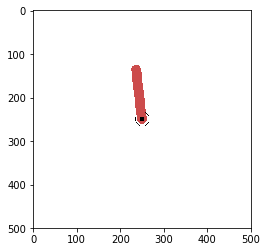

In [8]:
env = gym.make(ENV_NAME)
env = env.unwrapped

env.seed(RANDOMSEED)
np.random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
a_bound = env.action_space.high

ddpg = DDPG(a_dim, s_dim, a_bound)

ddpg.load_ckpt()
for i_episode in range(20):
    observation = env.reset()
    for t in range(100000):
        print(t)
        plt.imshow(env.render(mode='rgb_array'))# CHANGED
        ipythondisplay.clear_output(wait=True) # ADDED
        ipythondisplay.display(plt.gcf()) # ADDED
        action = ddpg.choose_action(observation)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break